In [154]:
from importlib import reload
import audioDatastore.AudioDatastore as myads
reload(myads)
import os.path
from collections import Counter
import random
from python_speech_features import mfcc
import scipy.io.wavfile as wav
from spafe.utils import vis
import matplotlib.pyplot as plt
import misc.vad as vad
reload(vad)

<module 'misc.vad' from 'C:\\Users\\David\\OneDrive\\Desktop\\pythonProjects\\ubm\\misc\\vad.py'>

In [146]:

datasetFolder = r"C:\Users\David\OneDrive\Desktop\matlab\data\speech_commands_v0.01"
main_ads = myads.AudioDatastore()
main_ads.populate(datasetFolder,include_sub_folders=True, label_source=True)

In [147]:
ads = myads.subset(main_ads, label='stop')

speakers = []
for file in ads.files:
    nm = os.path.basename(file)
    nm = nm.split('_')[0]
    speakers.append('a' + nm)

ads.set(labels=speakers)

In [148]:
num_speakers_to_enroll = 10
label_count = Counter(ads.labels)
for_enroll_and_test_set = []
for key, cnts in list(label_count.items()):
    if cnts >= 3:
        for_enroll_and_test_set.append(key)
for_enroll = random.sample(for_enroll_and_test_set, num_speakers_to_enroll)
ads_enroll_and_validate = myads.subset(ads, label=for_enroll)
ads_enroll, _ = myads.split(ads_enroll_and_validate, int(len(ads_enroll_and_validate.labels) / 2))
ads_test = myads.subset(ads, for_enroll_and_test_set)
ads_test = myads.filter(ads_test, ads_enroll.labels)
ads_train_ubm = myads.filter(ads, ads_test.labels)
ads_train_ubm = myads.filter(ads_train_ubm, ads_enroll.labels)

In [162]:
#  feature extraction

def helper_feature_extraction(audio_file):
    # read in file
    (rate,sig) = wav.read(audio_file)

    # normalise
    sig = sig / max(sig)

    # detect speech => convert this into one function
    v = vad.VoiceActivityDetector(rate, sig, 0.5)
    detected_speach = v.detect_speech()
    idx = v.convert_windows_to_readible_labels(detected_speach)
    if idx:
        sig = sig[idx[0]:idx[1]]
        mfcc_feat = mfcc(sig,rate)
        return mfcc_feat
    else:
        return []


In [164]:
import pickle

try:
    all_features = pickle.load(open('all_features.pickle','rb'))
except:
    all_features = []
    for file in ads.files:
        feature = helper_feature_extraction(file)
        all_features.append(feature)
    pickle.dump(all_features, open('all_features.pickle','wb'))


In [174]:
import numpy as np
normFactors = {}
# means = np.mean(all_features.fl, axis=0)
means = []
std = []
for feature in all_features:
    if len(feature) > 0:
        means.append(np.mean(feature, axis=0))
        std.append(np.std(feature, axis=0))

means = np.array(means)
means = np.mean(means, axis=0)

std = np.array(std)
std = np.std(std, axis=0)


In [177]:
# normalise features

for i in range(len(all_features)):
    if len(all_features[i]) > 0:
        all_features[i] = (all_features[i] - means) / std


In [158]:

empty_features = []
for i in range(len(all_features)):
    if len(all_features[i]) == 0:
        empty_features.append(i)

print('empty features count: ', len(empty_features))



empty features count:  139


In [ ]:
# book keeping




In [92]:
all_features[empty_features[0]]

[]

False


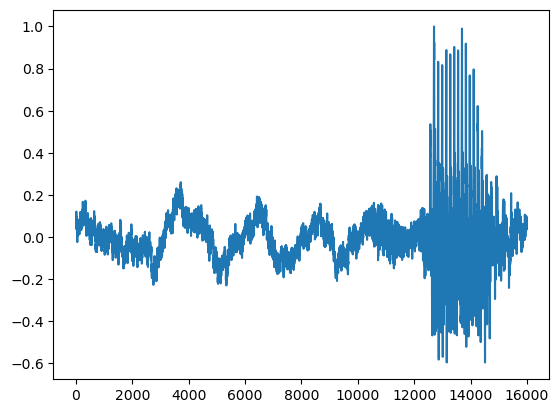

In [142]:
(rate,sig) = wav.read(ads.files[227])

# normalise
sig = sig / max(sig)

# detect speech => convert this into one function
v = vad.VoiceActivityDetector(rate, sig, 0.5)
detected_speach = v.detect_speech()
idx = v.convert_windows_to_readible_labels(detected_speach)

plt.plot(sig)
print(idx)